ResNet50 model 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm as notebook_tqdm
from datetime import datetime
import numpy as np 
import pandas as pd

from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from PIL import Image
import torch
import torchvision
from torchvision.models.resnet import resnet50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/volumes1/thesis/notebooks/notebook_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

In [3]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                         (0.2724, 0.2608, 0.2669)),
    transforms.ElasticTransform(alpha = 1.0)          # to re-create rainy weather conditions 
]) 

In [4]:
# defining hyperparameters 
#epochs = 31   #the nn will train 31 times over all 50.000 images and validate itself with 12.000 images x 31  times) 
epochs = 10 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [5]:
# loading dataset 
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [6]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=transforms,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7efea85e5100>, <torch.utils.data.dataloader.DataLoader object at 0x7efea8f51970>)


In [7]:
classes = [ '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons' ]

In [8]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [9]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [10]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [11]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [12]:
# training function

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [13]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

model = model.to(device)



In [14]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

12:26:09 --- Epoch: 0	Train loss: 2.6744	Valid loss: 1.6776	Train accuracy: 50.88	Valid accuracy: 48.25
12:28:04 --- Epoch: 1	Train loss: 1.0978	Valid loss: 0.7058	Train accuracy: 83.73	Valid accuracy: 78.64
12:29:57 --- Epoch: 2	Train loss: 0.4034	Valid loss: 0.3630	Train accuracy: 95.31	Valid accuracy: 88.81
12:31:52 --- Epoch: 3	Train loss: 0.1356	Valid loss: 0.2539	Train accuracy: 97.78	Valid accuracy: 92.17
12:33:45 --- Epoch: 4	Train loss: 0.0636	Valid loss: 0.2192	Train accuracy: 98.65	Valid accuracy: 93.75
12:35:40 --- Epoch: 5	Train loss: 0.0427	Valid loss: 0.2069	Train accuracy: 98.88	Valid accuracy: 93.98
12:37:32 --- Epoch: 6	Train loss: 0.0619	Valid loss: 0.2730	Train accuracy: 97.33	Valid accuracy: 92.36
12:39:24 --- Epoch: 7	Train loss: 0.0906	Valid loss: 0.2310	Train accuracy: 97.42	Valid accuracy: 93.19
12:41:18 --- Epoch: 8	Train loss: 0.0667	Valid loss: 0.1827	Train accuracy: 98.79	Valid accuracy: 94.78
12:43:12 --- Epoch: 9	Train loss: 0.0450	Valid loss: 0.1616	Trai

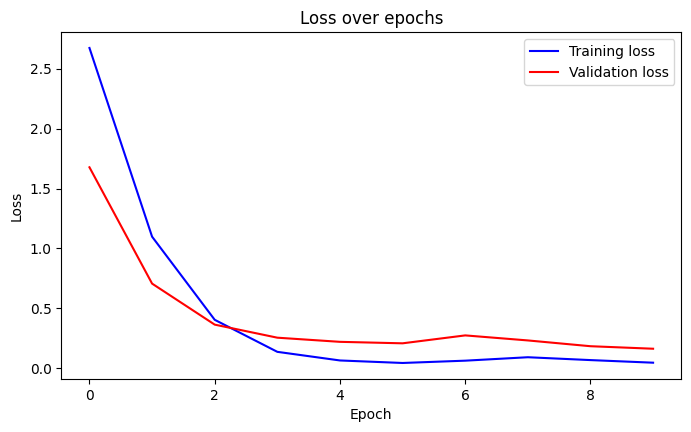

In [15]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [17]:

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classe
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)



Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Micro Sensitivity: 0.74

Macro Precision: 0.69
Macro Recall: 0.66
Macro F1-score: 0.66

Macro Sensitivity: 0.66

Weighted Precision: 0.76
Weighted Recall: 0.74
Weighted F1-score: 0.74
Weighted Sensitivity: 0.74


Classification Report

                                  precision    recall  f1-score   support

          0:Speed limit (20km/h)       0.34      0.28      0.31        60
          1:Speed limit (30km/h)       0.74      0.74      0.74       720
          2:Speed limit (50km/h)       0.62      0.79      0.70       750
          3:Speed limit (60km/h)       0.53      0.56      0.54       450
          4:Speed limit (70km/h)       0.75      0.69      0.72       660
          5:Speed limit (80km/h)       0.56      0.72      0.63       630
   6:End of speed limit (80km/h)       0.89      0.72      0.80       150
         7:Speed limit (100km/h)       0.72      0.64      0.68       450
         8:Speed 

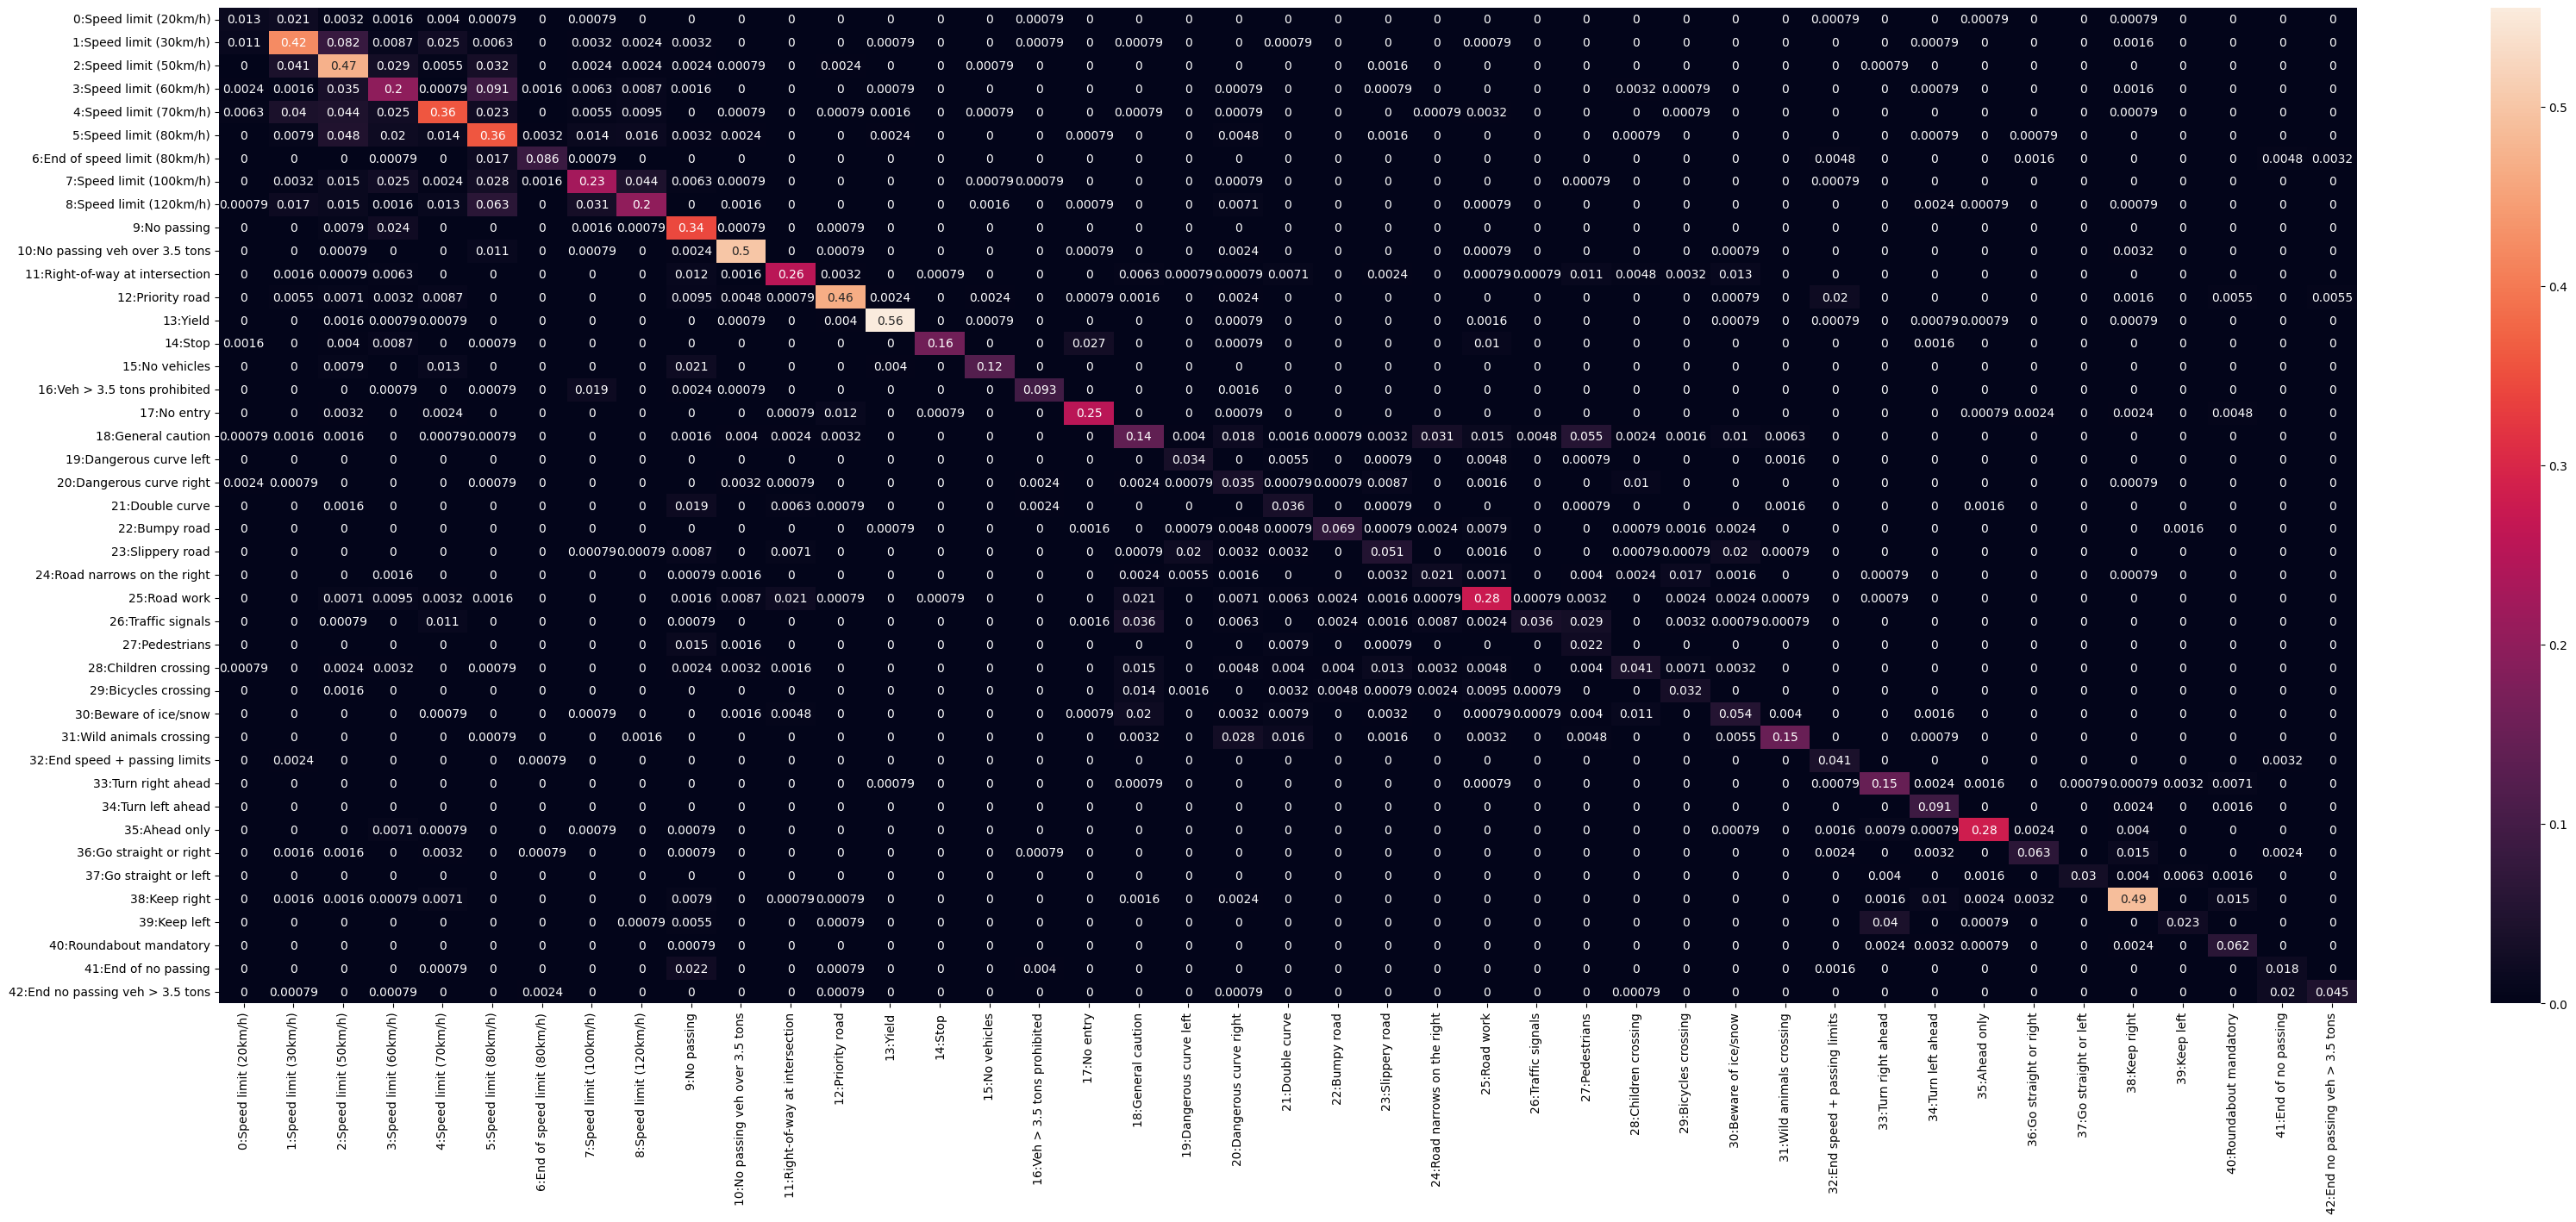

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))
print('Micro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))
print('Macro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))
print('Weighted Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='weighted')))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, target_names=['0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons']))

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('ResNet50_set4.png')

cf_report = classification_report(y_true, y_pred)
print(cf_report)
print(cf_matrix)

In [19]:
cf_report = classification_report(y_true, y_pred)
print(cf_report)

              precision    recall  f1-score   support

           0       0.34      0.28      0.31        60
           1       0.74      0.74      0.74       720
           2       0.62      0.79      0.70       750
           3       0.53      0.56      0.54       450
           4       0.75      0.69      0.72       660
           5       0.56      0.72      0.63       630
           6       0.89      0.72      0.80       150
           7       0.72      0.64      0.68       450
           8       0.70      0.56      0.62       450
           9       0.69      0.91      0.79       480
          10       0.93      0.95      0.94       660
          11       0.85      0.77      0.81       420
          12       0.94      0.85      0.89       690
          13       0.98      0.97      0.97       720
          14       0.99      0.74      0.85       270
          15       0.94      0.72      0.82       210
          16       0.89      0.79      0.83       150
          17       0.88    

In [22]:
data = {'y_actual':    y_true,
        'y_predicted': y_pred
        }

df = pd.DataFrame(data)

confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  0    1    2    3    4    5    6    7    8    9   ...   33   34  \
Actual                                                      ...             
0          17   26    4    2    5    1    0    1    0    0  ...    0    0   
1          14  533  103   11   32    8    0    4    3    4  ...    0    1   
2           0   52  596   37    7   41    0    3    3    3  ...    1    0   
3           3    2   44  251    1  115    2    8   11    2  ...    0    1   
4           8   50   55   31  454   29    0    7   12    0  ...    0    0   
5           0   10   60   25   18  453    4   18   20    4  ...    0    1   
6           0    0    0    1    0   22  108    1    0    0  ...    0    0   
7           0    4   19   31    3   35    2  287   55    8  ...    0    0   
8           1   22   19    2   16   79    0   39  252    0  ...    0    3   
9           0    0   10   30    0    0    0    2    1  435  ...    0    0   
10          0    0    1    0    0   14    0    1    0    3  ...    0    0   

In [23]:

data = {'y_actual':    y_true,
        'y_predicted': y_pred
        }

df = pd.DataFrame(data)
confusion_matrix = ConfusionMatrix(df['y_actual'], df['y_predicted'])
confusion_matrix.print_stats()


ModuleNotFoundError: No module named 'pandas_ml'